In [9]:
from __future__ import print_function

from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline


import flotilla
sns.set(style='ticks', context='talk')

folder = 'figures'
! mkdir $folder

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects/'

study = flotilla.embark('singlecell_pnm_miso_modalities', flotilla_dir=flotilla_dir)

mkdir: cannot create directory `figures': File exists
2016-07-21 08:57:17	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_miso_modalities/datapackage.json
2016-07-21 08:57:17	Parsing datapackage to create a Study object
2016-07-21 08:58:11 	Initializing Study
2016-07-21 08:58:11 	Initializing Predictor configuration manager for Study
2016-07-21 08:58:11	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-07-21 08:58:11	Added ExtraTreesClassifier to default predictors
2016-07-21 08:58:11	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-07-21 08:58:11	Added ExtraTreesRegressor to default predictors
2016-07-21 08:58:11	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-07-21 08:58:11	Added GradientBoostingClassifier to default predictors
2016-07-21 08:58:11	Predictor GradientB

In [10]:
same_in_all_three_modalities = study.supplemental.modalities_tidy.groupby(['modality', 'event_id']).filter(lambda x: len(x) == len(study.phenotype_order))
same_in_all_three_modalities.head()

,event_id,phenotype,modality
45,chr10:102045854:102045970:-@chr10:102042663:10...,MN,excluded
46,chr10:102045854:102045970:-@chr10:102042663:10...,NPC,excluded
47,chr10:102045854:102045970:-@chr10:102042663:10...,iPSC,excluded
48,chr10:102286156:102286311:-@chr10:102283734:10...,MN,excluded
49,chr10:102286156:102286311:-@chr10:102283734:10...,NPC,excluded


In [11]:
same_in_all_three_modalities.groupby('event_id')['modality']

In [12]:
same_in_all_three_modalities = same_in_all_three_modalities[['event_id', 'modality']].drop_duplicates()
same_in_all_three_modalities.head()

,event_id,modality
45,chr10:102045854:102045970:-@chr10:102042663:10...,excluded
48,chr10:102286156:102286311:-@chr10:102283734:10...,excluded
51,chr10:102286732:102286831:-@chr10:102286156:10...,included
72,chr10:102747070:102747272:-@chr10:102746847:10...,uncategorized
105,chr10:103360960:103361093:+@chr10:103368624:10...,excluded


In [13]:
same_in_all_three_modalities_splice_types = same_in_all_three_modalities.join(study.splicing.feature_data['splice_type'], on='event_id')
same_in_all_three_modalities_splice_types.head()

,event_id,modality,splice_type
45,chr10:102045854:102045970:-@chr10:102042663:10...,excluded,SE
48,chr10:102286156:102286311:-@chr10:102283734:10...,excluded,SE
51,chr10:102286732:102286831:-@chr10:102286156:10...,included,SE
72,chr10:102747070:102747272:-@chr10:102746847:10...,uncategorized,MXE
105,chr10:103360960:103361093:+@chr10:103368624:10...,excluded,SE


In [14]:
s = study.splicing.feature_data.loc[study.splicing.data.columns, 'splice_type']
all_events = s.groupby(s).size()
all_events.name = 'all'
all_events

splice_type
MXE     3925
SE     20517
Name: all, dtype: int64

In [15]:
splice_type_modalities = same_in_all_three_modalities_splice_types.groupby(['modality', 'splice_type']).size().unstack()
splice_type_modalities = splice_type_modalities.append(all_events)
splice_type_modalities

splice_type,MXE,SE
modality,,
bimodal,7,54
excluded,210,1520
included,164,1656
middle,15,2
uncategorized,342,657
all,3925,20517


In [16]:
tidy = splice_type_modalities.unstack().reset_index()
tidy = tidy.rename(columns={0: 'n_events'})
tidy

,splice_type,modality,n_events
0,MXE,bimodal,7
1,MXE,excluded,210
2,MXE,included,164
3,MXE,middle,15
4,MXE,uncategorized,342
5,MXE,all,3925
6,SE,bimodal,54
7,SE,excluded,1520
8,SE,included,1656
9,SE,middle,2


In [17]:
tidy['percentage_of_modality'] = tidy.groupby('modality')['n_events'].apply(lambda x: 100 * x/x.sum())
tidy

,splice_type,modality,n_events,percentage_of_modality
0,MXE,bimodal,7,11.475410
1,MXE,excluded,210,12.138728
2,MXE,included,164,9.010989
3,MXE,middle,15,88.235294
4,MXE,uncategorized,342,34.234234
5,MXE,all,3925,16.058424
6,SE,bimodal,54,88.524590
7,SE,excluded,1520,87.861272
8,SE,included,1656,90.989011
9,SE,middle,2,11.764706


In [20]:
sns.set(style='ticks', context='paper')

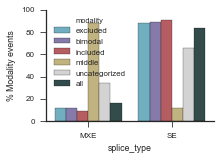

In [21]:
import anchor

hue_order = anchor.MODALITY_ORDER + ['all']
palette = anchor.MODALITY_PALETTE + ['DarkSlateGray']

fig, ax = plt.subplots(figsize=(3, 2))
sns.barplot(x='splice_type', y='percentage_of_modality', hue='modality', data=tidy, 
            hue_order=hue_order, palette=palette)
ax.set(ylabel='% Modality events')
sns.despine()
fig.savefig('{}/percent_modality_in_splice_types.pdf'.format(folder))

In [19]:
same_in_all_three_modalities_events = same_in_all_three_modalities.groupby('event_id')['modality']
same_in_all_three_modalities_events[:10]

NotImplementedError: Not implemented: slice(None, 10, None)

In [ ]:
figure_folder = '{}/same_in_all_phenotypes'.format(folder)

In [ ]:
middle_folder = '{}/middle'.format(figure_folder)

In [ ]:
mkdir -p $middle_folder

In [ ]:
middle_events = same_in_all_three_modalities.query('modality == "middle"')['event_id']
# middle_events[:10]

# len(middle_events)

for event in middle_events:
    gene_name = study.splicing.feature_data['gene_name'][event]
    study.plot_event(event)
    fig = plt.gcf()
    fig.savefig('{}/{}_{}.pdf'.format(middle_folder, gene_name, event))
plt.close('all')

In [87]:
uncategorized_folder = '{}/uncategorized'.format(figure_folder)

In [91]:
mkdir -p $uncategorized_folder

In [92]:
uncategorized_events = same_in_all_three_modalities.query('modality == "uncategorized"')['event_id']
# middle_events[:10]

# len(middle_events)

for event in uncategorized_events:
    gene_name = study.splicing.feature_data['gene_name'][event]
    study.plot_event(event)
    fig = plt.gcf()
    fig.savefig('{}/{}_{}.pdf'.format(uncategorized_folder, gene_name, event))
plt.close('all')